## Predicting Hazardous Bump during subsequent shifts using supervised learning

This notebook looks into building an ML model capabale of predicting Seismic Hazard, which is a seismic event with more than 1000 joules of energy. In other words, predicting the probability that an earthquake will occur in a given geographic area, based on seismic event attributes. 

### We'll go along with
![](6-step-ml-framework.png)

### 1. Problem Definition
Problem that'll be explored is a **binary classification** problem. 

This is because number of different features (pieces of information) about energy reading and bump counts in Zabrze-Bielszowice coal mine, Poland will be used to predict whether *high energy seismic bump* will occur in the next shift or not. A shift is an 8 hour period.

In a statement,

> Given seismic parameters about a coal mine, can we predict whether or not it is in 'Hazardous Stae' or 'Non-hazardous state'?

### 2. Data
The original data came from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/seismic-bumps)
However, the dataset is downloaded in a formatted way from [Kaggle](https://www.kaggle.com/pranabroy94/seismic-bumps-data-set)

Here 19 attributes will be used. **Attributes** (also called features) are the variables what we'll use to predict our target variable.

Attributes and features are also referred to as **independent variables** and a target variable can be referred to as a **dependent variable**.


### 3. Evaluation 
> If we can reach 95% accuracy at predicting whether or not the coal mine has hazardous bump during the proof of concept, we'll pursue the project.

### 4. Features
This is where different information about each of the features in dataset is clarified. This can be done by **own research** (such as looking at the links above) or by talking to a **subject matter expert** (someone who knows about the dataset). One of the most common ways to do this, is to create a **Data dictionary**.

*Independent Variables*

* seismic : Result of shift seismic hazard assessment obtained by seismic method a(lack of hazard), b(low hazard), c(high hazard), d(danger state) Seismic method is a geophysical prospecting method based on the fact that speed of transmission of shockwave through earth vary with the elastic constants and densities of rocks through which the wave passes
* seismoacoustic : Result of shift seismic hazard assessment obtained through seismoacoustic method.
* shift : Type of shifts w(coal getting), n(preparation shift)
* genergy : Seismic energy recorded within previous shift by the most active geophone out of all geophones monitoring the long wall
* gpuls : Number of pulses recorded within previous shift by the most active geophone
* gdenergy : A deviation of energy recorded within the previous shift by the most active geophone, from average energy recorded during eight previous shifts
* gdpuls : A deviation of a number of pulses recorded within previous shift by GMax from average number
* ghazard : result of shift seismic hazard assessment in the mine working obtained by the seismoacoustic method based on registration coming form GMax only
* energy : total energy of seismic bumps registered within previous shift
* maxenergy : the maximum energy of the seismic bumps registered within previous shift
* nbumps : the number of seismic bumps recorded within previous shift
* nbumps2 : the number of seismic bumps (in energy range [$10^2$, $10^3$)) registered within previous shift
* nbumps3 : the number of seismic bumps (in energy range [$10^3$,$10^4$)) registered within previous shift
* nbumps4 : the number of seismic bumps (in energy range [$10^4$,$10^5$)) registered within previous shift
* nbumps5 : the number of seismic bumps (in energy range [$10^5$,$10^6$)) registered within previous shift
* nbumps6 : the number of seismic bumps (in energy range [$10^6$,$10^7$)) registered within previous shift
* nbumps7 : the number of seismic bumps (in energy range [$10^7$,$10^8$)) registered within previous shift
* nbumps89 : the number of seismic bumps (in energy range [$10^8$,$10^{10}$)) registered within previous shift

*Dependent Variable*

* class : the decision attribute - "1" means that high energy seismic bump occurred in the next shift ("hazardous state"), "0" means that no high energy seismic bumps occurred in the next shift ("non-hazardous state")



### Preparing the tools

In [1]:
#Regular EDA 
import numpy as np
import pandas as pd
#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#plots to appear inside the notebook
%matplotlib inline

#Estimators
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC

#Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, plot_roc_curve

### Loading Data

In [2]:
data = pd.read_csv('seismic-bumps.csv')
nRow, nCol = data.shape
print(f'The dataset has {nRow} rows, {nCol} columns')

The dataset has 2584 rows, 19 columns


### Data Exploration (EDA)
Should be trying to become more and more familiar with the dataset. Compare different columns to each other, compare them to the target variable. Refer back to data dictionary and remind what different columns mean.

Goal is to become a subject matter expert on the dataset you're working with. When start building models, one can sound check them to make sure they're not performing too well (overfitting) or why they might be performing poorly (underfitting).

Since EDA has no real set methodolgy, the following is a short check list you might want to walk through:

1. What question(s) are you trying to solve (or prove wrong)?
2. What kind of data do you have and how do you treat different types?
3. What’s missing from the data and how do you deal with it?
4. Where are the outliers and why should you care about them?
5. How can you add, change or remove features to get more out of your data?

In [3]:
data.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,hazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,a,a,N,15180,48,-72,-72,a,0,0,0,0,0,0,0,0,0,0,0
1,a,a,N,14720,33,-70,-79,a,1,0,1,0,0,0,0,0,2000,2000,0
2,a,a,N,8050,30,-81,-78,a,0,0,0,0,0,0,0,0,0,0,0
3,a,a,N,28820,171,-23,40,a,1,0,1,0,0,0,0,0,3000,3000,0
4,a,a,N,12640,57,-63,-52,a,0,0,0,0,0,0,0,0,0,0,0


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2584 entries, 0 to 2583
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   seismic         2584 non-null   object
 1   seismoacoustic  2584 non-null   object
 2   shift           2584 non-null   object
 3   genergy         2584 non-null   int64 
 4   gpuls           2584 non-null   int64 
 5   gdenergy        2584 non-null   int64 
 6   gdpuls          2584 non-null   int64 
 7   hazard          2584 non-null   object
 8   nbumps          2584 non-null   int64 
 9   nbumps2         2584 non-null   int64 
 10  nbumps3         2584 non-null   int64 
 11  nbumps4         2584 non-null   int64 
 12  nbumps5         2584 non-null   int64 
 13  nbumps6         2584 non-null   int64 
 14  nbumps7         2584 non-null   int64 
 15  nbumps89        2584 non-null   int64 
 16  energy          2584 non-null   int64 
 17  maxenergy       2584 non-null   int64 
 18  class   

In [3]:
# Are there any missing values?
data.isnull().sum().sort_values()

seismic           0
energy            0
nbumps89          0
nbumps7           0
nbumps6           0
nbumps5           0
nbumps4           0
nbumps3           0
maxenergy         0
nbumps2           0
hazard            0
gdpuls            0
gdenergy          0
gpuls             0
genergy           0
shift             0
seismoacoustic    0
nbumps            0
class             0
dtype: int64

In [6]:
# # Data cleaning
# for i in range(len(cols)):
#     if data[cols[i]].isna().sum()==data.shape[0]:
#         data.drop([cols[i]], axis=1, inplace=True) 

In [13]:
cols = data.columns.tolist()

dick = {}
for j in range(len(cols)):
    dick[cols[j]] = len(data[cols[j]].unique())   # dropping the attributes that have constant value.
    
print(dick)

{'seismic': 2, 'seismoacoustic': 3, 'shift': 2, 'genergy': 2212, 'gpuls': 1128, 'gdenergy': 334, 'gdpuls': 292, 'hazard': 3, 'nbumps': 10, 'nbumps2': 7, 'nbumps3': 7, 'nbumps4': 4, 'nbumps5': 2, 'energy': 242, 'maxenergy': 33, 'class': 2}


In [5]:
for j in range(len(cols)):
    if len(data[cols[j]].unique())==1:
        data.drop(cols[j], axis=1, inplace=True)

In [6]:
haz_stat = data['class'].value_counts()

<AxesSubplot:>

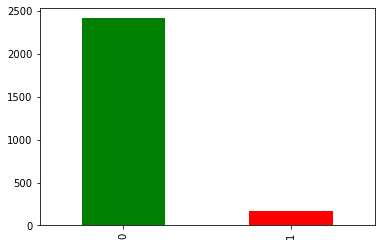

In [7]:
# Visualizing how many of each class are there
haz_stat.plot.bar(color=['green', 'red'])

In [8]:
data.describe()

,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,energy,maxenergy,class
count,2.584000e+03,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,9.024252e+04,538.579334,12.375774,4.508901,0.859520,0.393576,0.392802,0.067724,0.004644,4975.270898,4278.850619,0.065789
std,2.292005e+05,562.652536,80.319051,63.166556,1.364616,0.783772,0.769710,0.279059,0.068001,20450.833222,19357.454882,0.247962
min,1.000000e+02,2.000000,-96.000000,-96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.166000e+04,190.000000,-37.000000,-36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.548500e+04,379.000000,-6.000000,-6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.283250e+04,669.000000,38.000000,30.250000,1.000000,1.000000,1.000000,0.000000,0.000000,2600.000000,2000.000000,0.000000
max,2.595650e+06,4518.000000,1245.000000,838.000000,9.000000,8.000000,7.000000,3.000000,1.000000,402000.000000,400000.000000,1.000000


In [9]:
data.groupby('class').agg(['mean', 'median'])

genergy              gpuls          gdenergy           gdpuls  \
                mean median        mean median       mean median      mean   
class                                                                        
0       82448.918807  24340  508.567109  364.0  12.312759     -6  4.143745   
1      200911.705882  59600  964.752941  697.5  13.270588     -4  9.694118   

                nbumps         ...   nbumps3          nbumps4         \
      median      mean median  ...      mean median      mean median   
class                          ...                                     
0         -6  0.769677      0  ...  0.350870      0  0.062138      0   
1          0  2.135294      2  ...  0.988235      1  0.147059      0   

        nbumps5              energy           maxenergy         
           mean median         mean median         mean median  
class                                                           
0      0.004557      0  4658.222867      0  4072.162386      0  
1      0.005882      0  9477.352941   3200  7213.823529   2000  

[2 rows x 22 columns]

### Seismic Bump frequency according to `seismic` attribute

In [10]:
data.seismic.unique()

array(['a', 'b'], dtype=object)

In [11]:
data.seismic.value_counts()

a    1682
b     902
Name: seismic, dtype: int64

In [12]:
pd.crosstab(data.seismic, data['class'])

class,0,1
seismic,,
a,1599,83
b,815,87


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

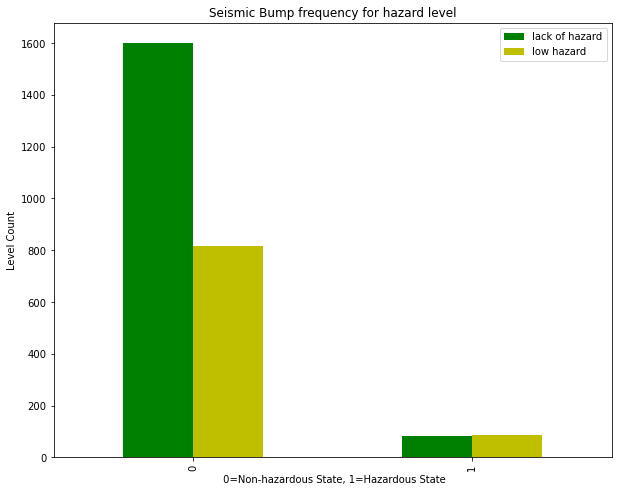

In [14]:
pd.crosstab(data['class'], data.seismic).plot.bar(figsize=(10,8), color= ['g', 'y'])
plt.title('Seismic Bump frequency for hazard level')
plt.xlabel(' 0=Non-hazardous State, 1=Hazardous State')
plt.ylabel('Level Count')
plt.legend(['lack of hazard', 'low hazard'])
plt.xticks(rotation=90)

### Seismic Energy vs. Number of Pulses for seismic bumps 

In [15]:
min(data.genergy), min(data.gdpuls)

(100, -96)

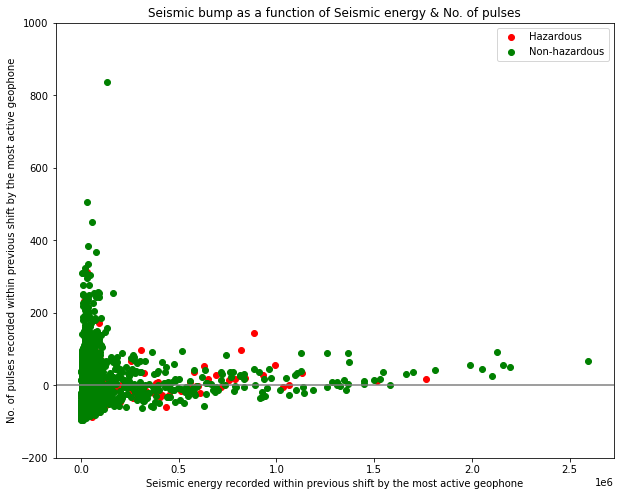

In [16]:
plt.figure(figsize=(10,8))
plt.ylim(-200, 1000)
plt.scatter(data.genergy[data['class']==1],
            data.gdpuls[data['class']==1],
            c = 'r')
plt.scatter(data.genergy[data['class']==0],
            data.gdpuls[data['class']==0],
            c = 'g')
plt.title('Seismic bump as a function of Seismic energy & No. of pulses')
plt.xlabel('Seismic energy recorded within previous shift by the most active geophone')
plt.ylabel('No. of pulses recorded within previous shift by the most active geophone')
plt.legend(['Hazardous', 'Non-hazardous'])
plt.axhline(0, color='grey')

<AxesSubplot:>

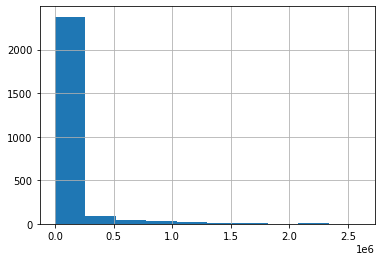

In [17]:
data.genergy.hist()

In [18]:
len(data.nbumps[data['class']==1])

170

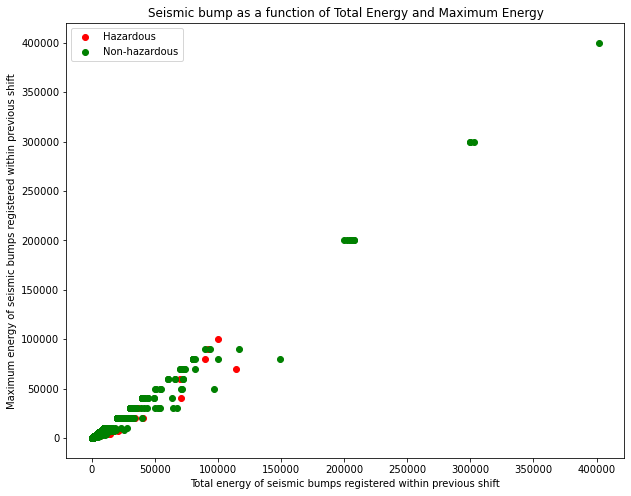

In [19]:
plt.figure(figsize=(10,8))
plt.scatter(data.energy[data['class']==1],
            data.maxenergy[data['class']==1],
            c = 'r')
plt.scatter(data.energy[data['class']==0],
            data.maxenergy[data['class']==0],
            c = 'g')
plt.title('Seismic bump as a function of Total Energy and Maximum Energy')
plt.xlabel('Total energy of seismic bumps registered within previous shift')
plt.ylabel('Maximum energy of seismic bumps registered within previous shift')
plt.legend(['Hazardous', 'Non-hazardous'])

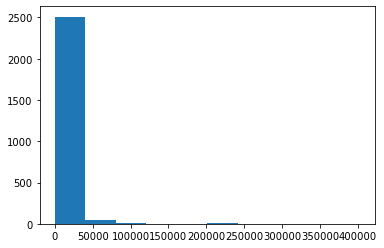

In [20]:
plt.hist(data.energy);

### Seismic bump frequency as per hazard type
result of shift seismic hazard assessment in the mine working obtained by the seismoacoustic method based on registration coming form GMax only.
* a:-lack of hazard
* b:-low hazard
* c:-high hazard

In [21]:
cros = pd.crosstab(data.hazard, data['class'])
cros

class,0,1
hazard,,
a,2186,156
b,198,14
c,30,0


(array([0, 1, 2]), [Text(0, 0, 'a'), Text(1, 0, 'b'), Text(2, 0, 'c')])

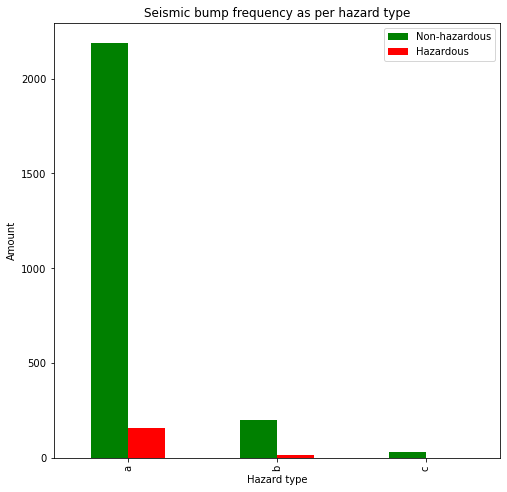

In [22]:
cros.plot(kind='bar', figsize=(8,8), color= ['g', 'r'])
plt.title('Seismic bump frequency as per hazard type')
plt.xlabel('Hazard type')
plt.ylabel('Amount')
plt.legend(['Non-hazardous', 'Hazardous'])
plt.xticks(rotation=90)

In [32]:
len(data.gpuls.unique())

1128

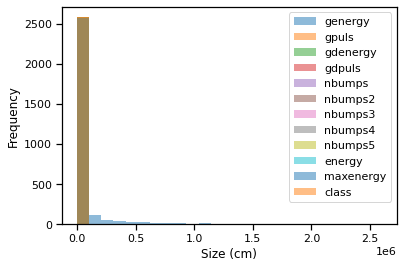

In [27]:
sns.set_context('notebook')

ax = data.plot.hist(bins=25, alpha=0.5)
ax.set_xlabel('Size (cm)');

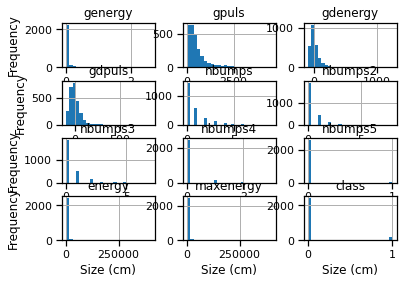

In [28]:
# Creating separate plots
axList = data.hist(bins=25)

# Adding some x- and y- labels to first column and last row
for ax in axList.flatten():
    if ax.is_last_row():
        ax.set_xlabel('Size (cm)')
        
    if ax.is_first_col():
        ax.set_ylabel('Frequency')

In [29]:
plot_data = (data
             .set_index('class')
             .stack()
             .to_frame()
             .reset_index()
             .rename(columns={0:'size', 'level_1':'attributes'})
            )

plot_data

,class,attributes,size
0,0,seismic,a
1,0,seismoacoustic,a
2,0,shift,N
3,0,genergy,15180
4,0,gpuls,48
...,...,...,...
38755,0,nbumps3,0
38756,0,nbumps4,0
38757,0,nbumps5,0
38758,0,energy,0


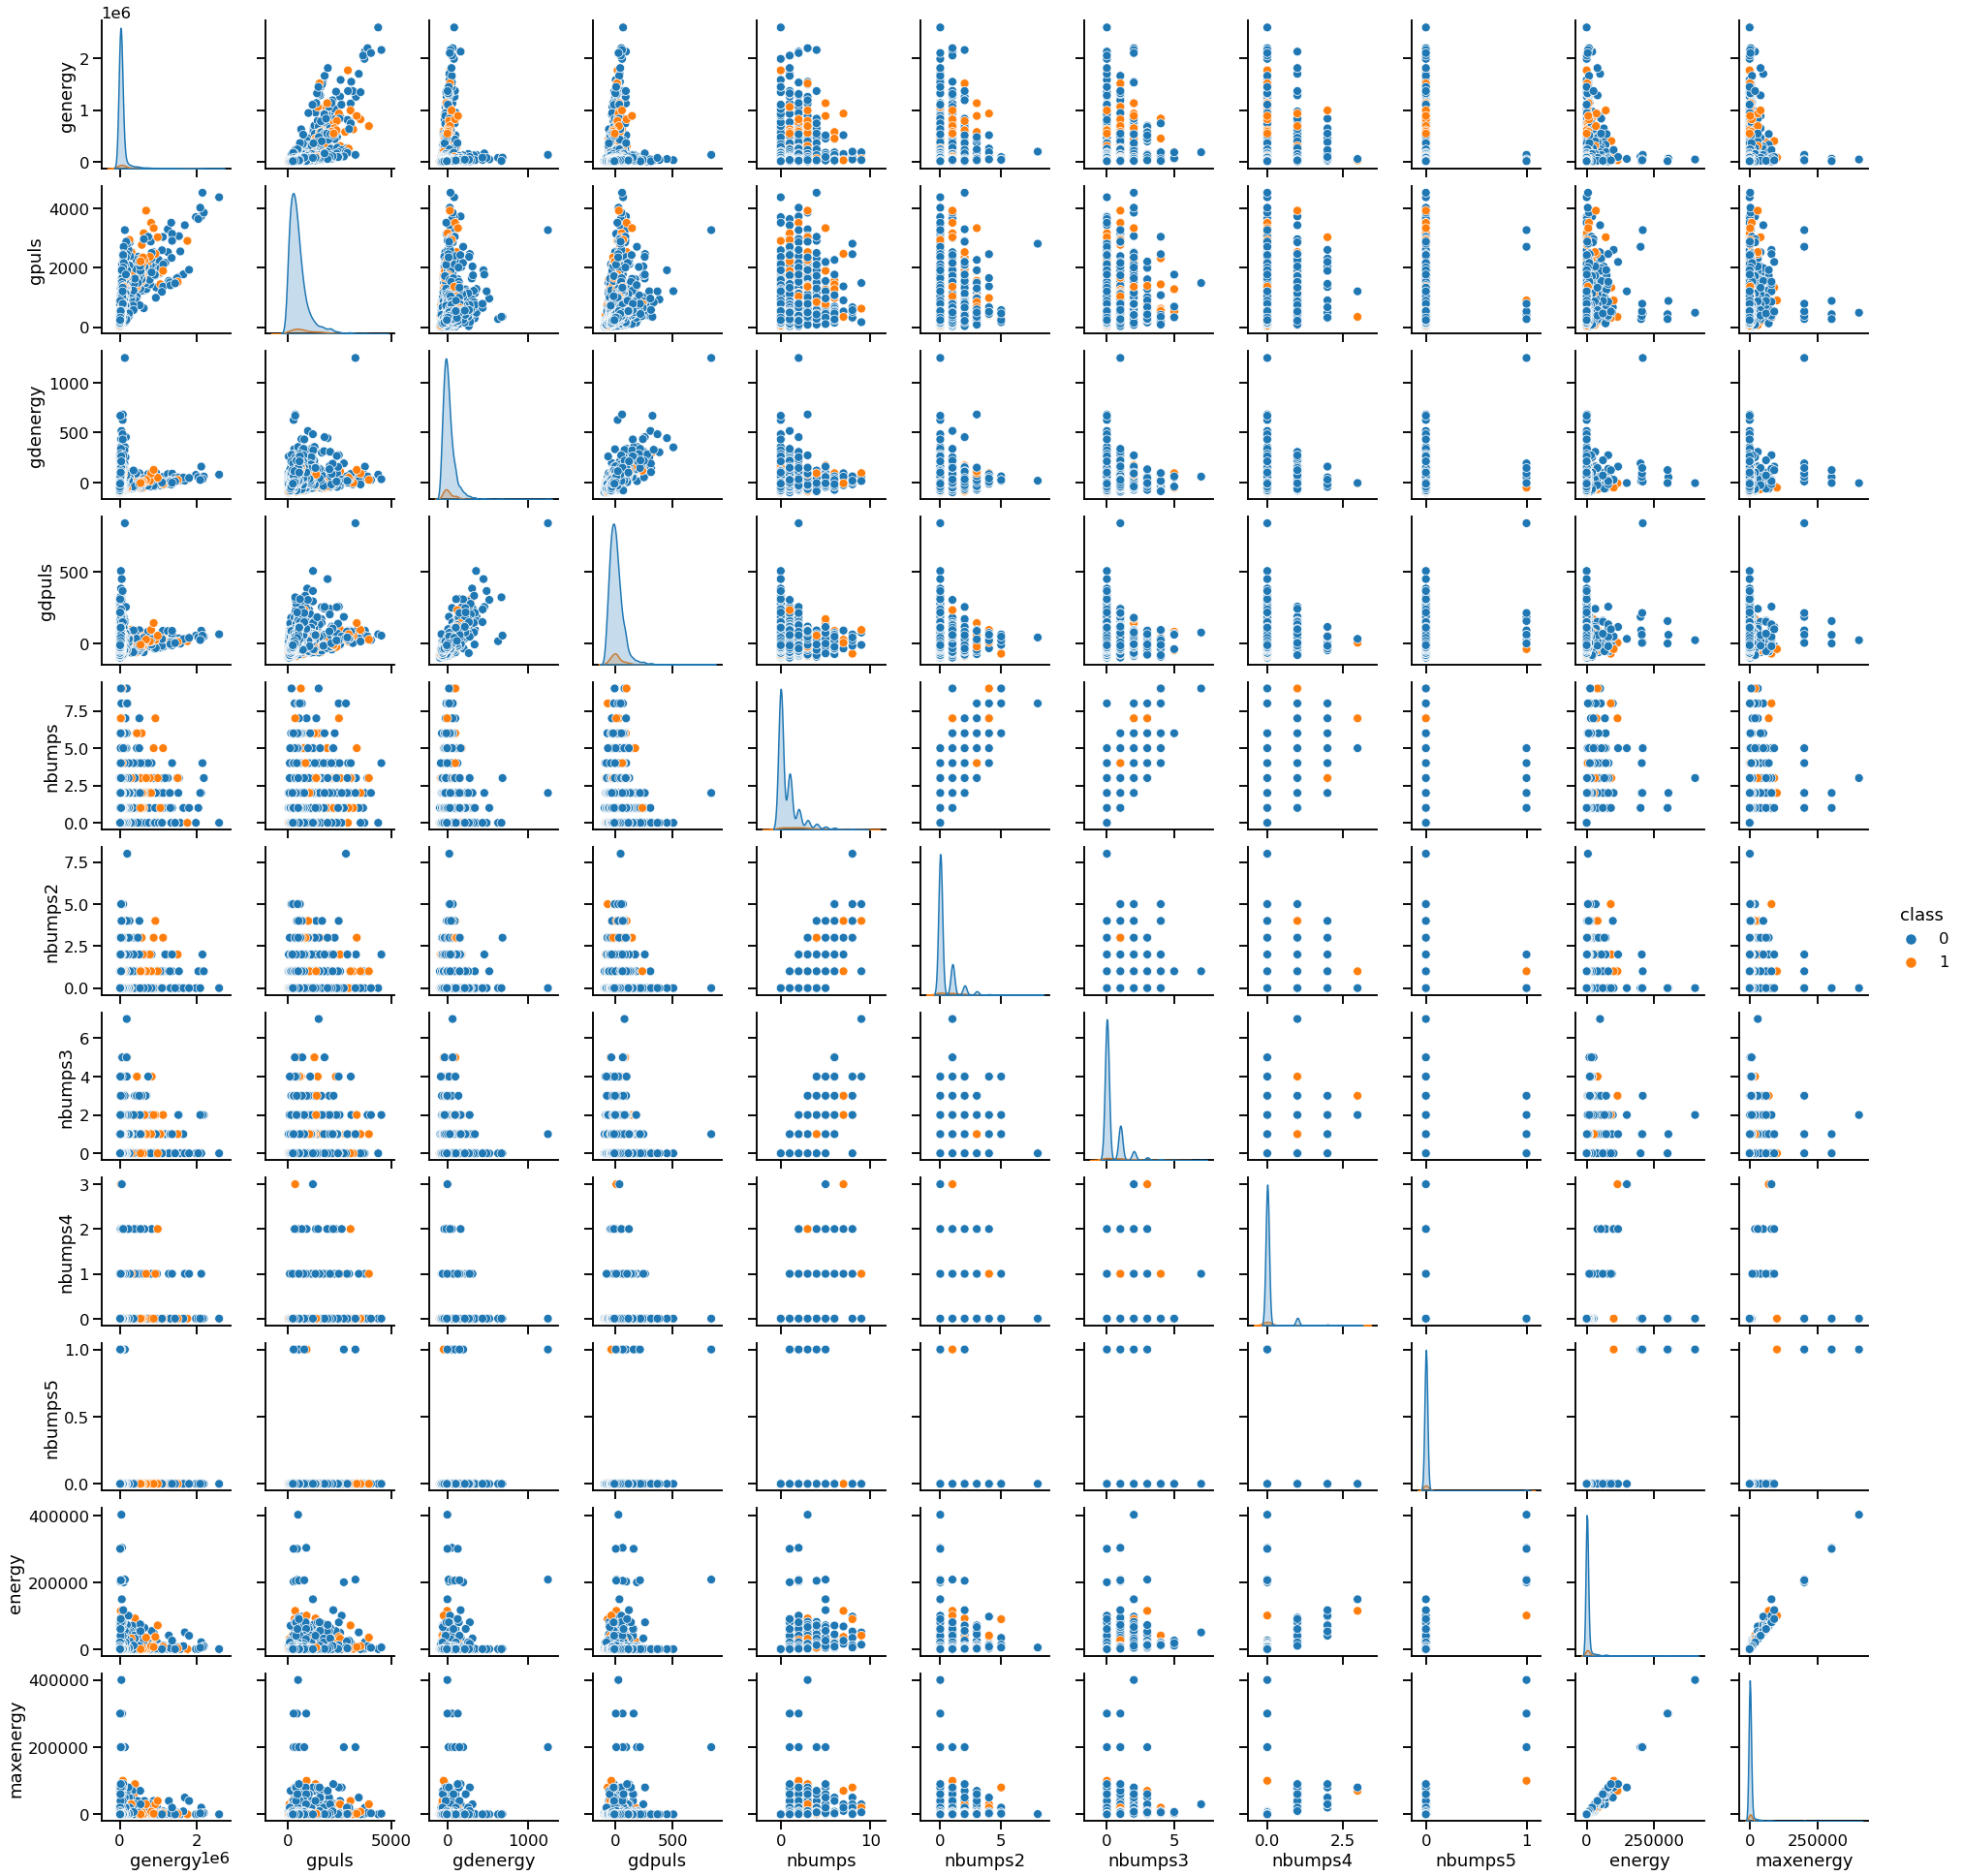

In [31]:
## Pairwise relationships in the dataset.
sns.set_context('talk')
sns.pairplot(data, hue='class');

In [32]:
data.corr()

,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,energy,maxenergy,class
genergy,1.000000,0.748020,0.048514,0.071554,0.220720,0.143587,0.191753,0.150589,-0.009863,0.080828,0.064405,0.128160
gpuls,0.748020,1.000000,0.293036,0.382906,0.300923,0.207390,0.225695,0.256547,0.049450,0.187350,0.164263,0.201042
gdenergy,0.048514,0.293036,1.000000,0.811944,0.030039,0.041246,-0.012189,0.036916,0.123229,0.105971,0.108572,0.002957
gdpuls,0.071554,0.382906,0.811944,1.000000,0.057996,0.051106,0.014735,0.066195,0.141044,0.143277,0.143646,0.021788
nbumps,0.220720,0.300923,0.030039,0.057996,1.000000,0.804978,0.803364,0.395052,0.069613,0.347852,0.273714,0.248144
nbumps2,0.143587,0.207390,0.041246,0.051106,0.804978,1.000000,0.350724,0.161296,-0.005251,0.124650,0.085032,0.201381
nbumps3,0.191753,0.225695,-0.012189,0.014735,0.803364,0.350724,1.000000,0.175301,0.046498,0.244083,0.176480,0.205327
nbumps4,0.150589,0.256547,0.036916,0.066195,0.395052,0.161296,0.175301,1.000000,-0.016580,0.489828,0.416483,0.075458
nbumps5,-0.009863,0.049450,0.123229,0.141044,0.069613,-0.005251,0.046498,-0.016580,1.000000,0.773605,0.808406,0.004834
energy,0.080828,0.187350,0.105971,0.143277,0.347852,0.124650,0.244083,0.489828,0.773605,1.000000,0.989547,0.058431


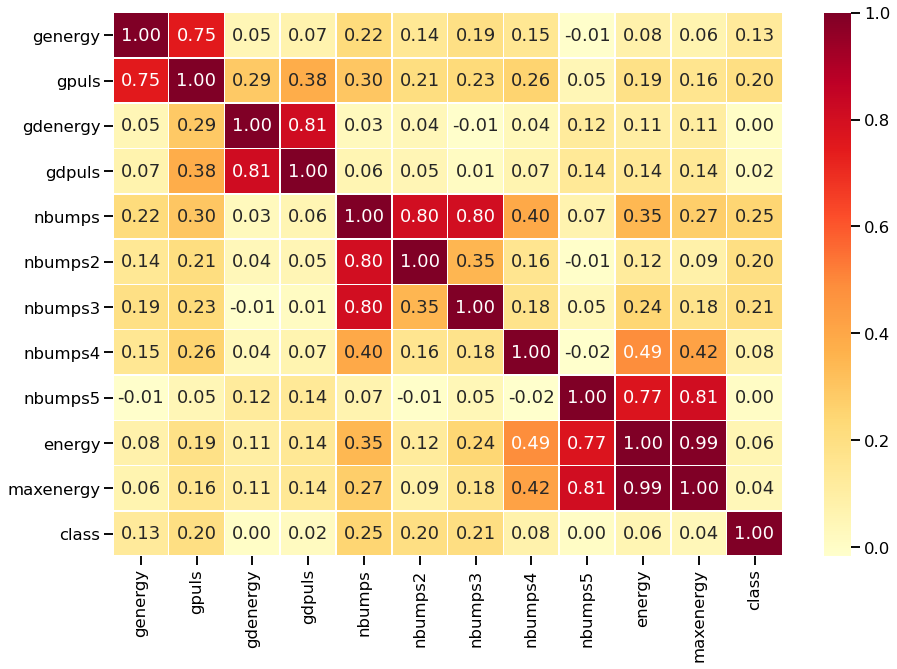

In [36]:
cor_mat = data.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(cor_mat, 
                 annot=True, 
                 fmt='0.2f', 
                 linewidths=0.5,
                 cmap='YlOrRd')

### 5. Modeling

In [37]:
data.dtypes

seismic           object
seismoacoustic    object
shift             object
genergy            int64
gpuls              int64
gdenergy           int64
gdpuls             int64
hazard            object
nbumps             int64
nbumps2            int64
nbumps3            int64
nbumps4            int64
nbumps5            int64
energy             int64
maxenergy          int64
class              int64
dtype: object

***Converting categorical variables into numerical***

In [38]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

cat_feats=['seismic', 'seismoacoustic', 'shift', 'hazard']
cat_trans = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

In [39]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('category', cat_trans, cat_feats)])
preprocessor

ColumnTransformer(transformers=[('category',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['seismic', 'seismoacoustic', 'shift',
                                  'hazard'])])

In [40]:
# Create X (all columns except target)
X = data.drop('class', axis=1)

# Create y (only the target column)
y = data['class']

In [42]:
# Use train_test_split to split X & y into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=666)
X_train, y_test

(     seismic seismoacoustic shift  genergy  gpuls  gdenergy  gdpuls hazard  \
 2349       b              a     N    22710    385        82      54      a   
 1317       a              b     W    12430    187       -32     -41      a   
 384        b              a     W   110510    708       -58     -58      a   
 1061       a              a     N     4720     26        73     -35      a   
 58         a              a     N    37360    171       -21       0      a   
 ...      ...            ...   ...      ...    ...       ...     ...    ...   
 1993       b              b     W    47200    562        91      24      b   
 70         a              a     W   590510   1780        23      -6      a   
 1950       a              a     W    11610    315       -21       3      a   
 1922       a              a     N     9000    241        31      40      a   
 2284       b              b     W    49120    485        96      -3      a   
 
       nbumps  nbumps2  nbumps3  nbumps4  nbumps5 

We're going to try 3 different ML models:

1. Logistic Regression
2. K-Nearest Neighbours Classifier
3. Random Forest Classifier

In [43]:
def fit_n_score(estimators, trainX, testX, train_y, test_y):
    ''' Fits and evaluates given machine learning models'''
    np.random.seed(666)
    scores = {}
    for name, model in estimators.items():
        model_pip = Pipeline(steps=[('preprocess', preprocessor),
                                     ('ML_model', model)])
        model_pip.fit(trainX, train_y)
        scores[name] = model_pip.score(testX, test_y)
        
    return scores

In [44]:
algos = {'Logistic Regression' : LogisticRegression(),
        'K-Nearest Neighbors' :KNeighborsClassifier(),
        'Random Forest Classifier' : RandomForestClassifier(),
        'Support Vector Classifier' : SVC(),
        'Linear Support Vector Classifier' : LinearSVC()}

mod_scor = fit_n_score(algos, X_train, X_test, y_train, y_test)
mod_scor

{'Logistic Regression': 0.9427244582043344,
 'K-Nearest Neighbors': 0.9427244582043344,
 'Random Forest Classifier': 0.9427244582043344,
 'Support Vector Classifier': 0.9427244582043344,
 'Linear Support Vector Classifier': 0.9427244582043344}

### Model comparison

<AxesSubplot:>

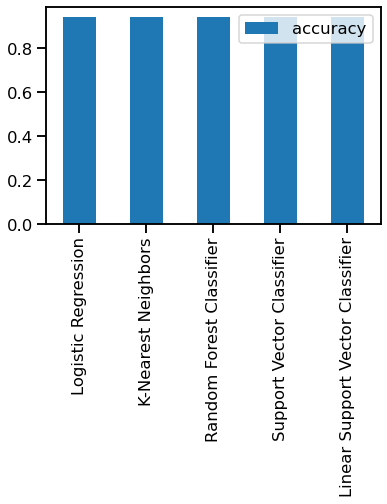

In [45]:
mod_com = pd.DataFrame(mod_scor, index=['accuracy'])
mod_com.T.plot(kind='bar')

We've got baseline models. A model's first predictions aren't always what next steps should be based off.

Let's look at the following:

* Hypyterparameter tuning
* Feature importance
* Confusion matrix
* Cross-validation

(*these are exclusively for classification problem*)
* Precision
* Recall
* F1 score
* Classification report
* ROC curve
* Area under the curve (AUC)

### Hyperparameter tuning by hand

In [46]:
train_scores=[]
test_scores= []
knn = Pipeline(steps=[('preprocess', preprocessor),
                      ('model', KNeighborsClassifier())])
for i in range(20):
    KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    tra=knn.score(X_train, y_train)
    tes=knn.score(X_test, y_test)
    train_scores.append(tra)
    test_scores.append(tes)

In [47]:
train_scores, test_scores;

Maximum KNN score on the test data: 94.27%


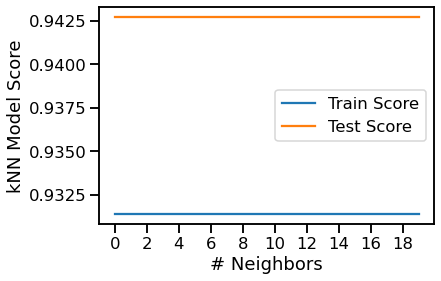

In [49]:
plt.plot(range(20), train_scores, label='Train Score')
plt.plot(range(20), test_scores, label='Test Score')
plt.xticks(np.arange(0, 20, 2))
plt.xlabel('# Neighbors')
plt.ylabel('kNN Model Score')
plt.legend()

print(f"Maximum KNN score on the test data: {max(test_scores)*100:.2f}%")

#### Hyperparameter tuning with RandomizedSearchCV
We're going to tune:

* LogisticRegression()
* RandomForestClassifier()
 

In [52]:
est = Pipeline(steps=[('preprocess', preprocessor),
                      ('ml_model', LogisticRegression())])

In [53]:
rsCV_grid = {"ml_model__C": np.logspace(-4, 4, 30),
             "ml_model__solver": ["liblinear"]}

In [54]:
rsCV_log_reg = RandomizedSearchCV(est,
                                  rsCV_grid,
                                  n_iter=20,
                                  cv=5,
                                  verbose=2)

In [55]:
rsCV_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] ml_model__solver=liblinear, ml_model__C=0.01610262027560939 .....
[CV]  ml_model__solver=liblinear, ml_model__C=0.01610262027560939, total=   0.2s
[CV] ml_model__solver=liblinear, ml_model__C=0.01610262027560939 .....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  ml_model__solver=liblinear, ml_model__C=0.01610262027560939, total=   0.0s
[CV] ml_model__solver=liblinear, ml_model__C=0.01610262027560939 .....
[CV]  ml_model__solver=liblinear, ml_model__C=0.01610262027560939, total=   0.0s
[CV] ml_model__solver=liblinear, ml_model__C=0.01610262027560939 .....
[CV]  ml_model__solver=liblinear, ml_model__C=0.01610262027560939, total=   0.0s
[CV] ml_model__solver=liblinear, ml_model__C=0.01610262027560939 .....
[CV]  ml_model__solver=liblinear, ml_model__C=0.01610262027560939, total=   0.0s
[CV] ml_model__solver=liblinear, ml_model__C=0.0001 ..................
[CV] ... ml_model__solver=liblinear, ml_model__C=0.0001, total=   0.0s
[CV] ml_model__solver=liblinear, ml_model__C=0.0001 ..................
[CV] ... ml_model__solver=liblinear, ml_model__C=0.0001, total=   0.0s
[CV] ml_model__solver=liblinear, ml_model__C=0.0001 ..................
[CV] ... ml_model__solver=liblinear, ml_model__C=0.0001, total=   0.0s
[CV] ml_model__solver=liblinear, ml_m

[CV]  ml_model__solver=liblinear, ml_model__C=5298.316906283702, total=   0.0s
[CV] ml_model__solver=liblinear, ml_model__C=5298.316906283702 .......
[CV]  ml_model__solver=liblinear, ml_model__C=5298.316906283702, total=   0.0s
[CV] ml_model__solver=liblinear, ml_model__C=5298.316906283702 .......
[CV]  ml_model__solver=liblinear, ml_model__C=5298.316906283702, total=   0.0s
[CV] ml_model__solver=liblinear, ml_model__C=5298.316906283702 .......
[CV]  ml_model__solver=liblinear, ml_model__C=5298.316906283702, total=   0.0s
[CV] ml_model__solver=liblinear, ml_model__C=17.433288221999874 ......
[CV]  ml_model__solver=liblinear, ml_model__C=17.433288221999874, total=   0.0s
[CV] ml_model__solver=liblinear, ml_model__C=17.433288221999874 ......
[CV]  ml_model__solver=liblinear, ml_model__C=17.433288221999874, total=   0.0s
[CV] ml_model__solver=liblinear, ml_model__C=17.433288221999874 ......
[CV]  ml_model__solver=liblinear, ml_model__C=17.433288221999874, total=   0.0s
[CV] ml_model__sol

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('category',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['seismic',
                                                                                'seismoacoustic',
                                                                                'shift',
                                                                                'hazard'])])),
                                             ('ml_model',
                                              LogisticRegression())]),
                   n_iter=20,
                   param_distributions={'ml_mo

In [56]:
rsCV_log_reg.best_params_

{'ml_model__solver': 'liblinear', 'ml_model__C': 0.01610262027560939}

In [57]:
rsCV_log_reg.score(X_test, y_test)

0.9427244582043344

doing the same for RandomForestClassifier()..

In [58]:
esti = Pipeline(steps=[('preprocess', preprocessor),
                       ('ml_model', RandomForestClassifier())])

In [59]:
rf_grid = {'ml_model__n_estimators' :np.arange(100, 1000, 400),
           'ml_model__max_depth':[None, 1, 25],
           'ml_model__min_samples_split' : np.arange(3, 10, 3),
           'ml_model__min_samples_leaf':np.arange(1, 20, 7),
           'ml_model__max_features':['sqrt']
          }

In [60]:
rs_rf = RandomizedSearchCV(esti,
                          rf_grid,
                          n_iter = 20,
                          cv=5,
                          verbose=True)
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.3min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('category',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['seismic',
                                                                                'seismoacoustic',
                                                                                'shift',
                                                                                'hazard'])])),
                                             ('ml_model',
                                              RandomForestClassifier())]),
                   n_iter=20,
                   param_distributions={'m

In [62]:
rs_rf.score(X_test, y_test)

0.9427244582043344

In [63]:
rs_rf.best_params_

{'ml_model__n_estimators': 900,
 'ml_model__min_samples_split': 3,
 'ml_model__min_samples_leaf': 8,
 'ml_model__max_features': 'sqrt',
 'ml_model__max_depth': None}

#### Hyperparameter tuning with GridSearchCV
trying to improve model scores again using GridSearchCV

In [69]:
estm = Pipeline(steps=[('preprocess', preprocessor),
                      ('ml_model', LogisticRegression())])

gsCV_grid = {"ml_model__C": np.logspace(-4, 4, 30),
             "ml_model__solver": ["liblinear"]}

gsCV_log_reg = GridSearchCV(estm,
                            gsCV_grid,
                            cv=5,
                            verbose=2)
gsCV_log_reg.fit(X_train, y_train);

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] ml_model__C=0.0001, ml_model__solver=liblinear ..................
[CV] ... ml_model__C=0.0001, ml_model__solver=liblinear, total=   0.0s
[CV] ml_model__C=0.0001, ml_model__solver=liblinear ..................
[CV] ... ml_model__C=0.0001, ml_model__solver=liblinear, total=   0.0s
[CV] ml_model__C=0.0001, ml_model__solver=liblinear ..................
[CV] ... ml_model__C=0.0001, ml_model__solver=liblinear, total=   0.0s
[CV] ml_model__C=0.0001, ml_model__solver=liblinear ..................
[CV] ... ml_model__C=0.0001, ml_model__solver=liblinear, total=   0.0s
[CV] ml_model__C=0.0001, ml_model__solver=liblinear ..................
[CV] ... ml_model__C=0.0001, ml_model__solver=liblinear, total=   0.0s
[CV] ml_model__C=0.00018873918221350977, ml_model__solver=liblinear ..
[CV]  ml_model__C=0.00018873918221350977, ml_model__solver=liblinear, total=   0.0s
[CV] ml_model__C=0.00018873918221350977, ml_model__solver=liblinear ..
[C

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  ml_model__C=0.0006723357536499335, ml_model__solver=liblinear, total=   0.0s
[CV] ml_model__C=0.0012689610031679222, ml_model__solver=liblinear ...
[CV]  ml_model__C=0.0012689610031679222, ml_model__solver=liblinear, total=   0.0s
[CV] ml_model__C=0.0012689610031679222, ml_model__solver=liblinear ...
[CV]  ml_model__C=0.0012689610031679222, ml_model__solver=liblinear, total=   0.0s
[CV] ml_model__C=0.0012689610031679222, ml_model__solver=liblinear ...
[CV]  ml_model__C=0.0012689610031679222, ml_model__solver=liblinear, total=   0.0s
[CV] ml_model__C=0.0012689610031679222, ml_model__solver=liblinear ...
[CV]  ml_model__C=0.0012689610031679222, ml_model__solver=liblinear, total=   0.0s
[CV] ml_model__C=0.0012689610031679222, ml_model__solver=liblinear ...
[CV]  ml_model__C=0.0012689610031679222, ml_model__solver=liblinear, total=   0.0s
[CV] ml_model__C=0.002395026619987486, ml_model__solver=liblinear ....
[CV]  ml_model__C=0.002395026619987486, ml_model__solver=liblinear, total=  

[CV]  ml_model__C=1.3738237958832638, ml_model__solver=liblinear, total=   0.0s
[CV] ml_model__C=1.3738237958832638, ml_model__solver=liblinear ......
[CV]  ml_model__C=1.3738237958832638, ml_model__solver=liblinear, total=   0.0s
[CV] ml_model__C=1.3738237958832638, ml_model__solver=liblinear ......
[CV]  ml_model__C=1.3738237958832638, ml_model__solver=liblinear, total=   0.0s
[CV] ml_model__C=1.3738237958832638, ml_model__solver=liblinear ......
[CV]  ml_model__C=1.3738237958832638, ml_model__solver=liblinear, total=   0.0s
[CV] ml_model__C=1.3738237958832638, ml_model__solver=liblinear ......
[CV]  ml_model__C=1.3738237958832638, ml_model__solver=liblinear, total=   0.0s
[CV] ml_model__C=2.592943797404667, ml_model__solver=liblinear .......
[CV]  ml_model__C=2.592943797404667, ml_model__solver=liblinear, total=   0.0s
[CV] ml_model__C=2.592943797404667, ml_model__solver=liblinear .......
[CV]  ml_model__C=2.592943797404667, ml_model__solver=liblinear, total=   0.0s
[CV] ml_model__C

[CV] .. ml_model__C=10000.0, ml_model__solver=liblinear, total=   0.0s
[CV] ml_model__C=10000.0, ml_model__solver=liblinear .................
[CV] .. ml_model__C=10000.0, ml_model__solver=liblinear, total=   0.0s
[CV] ml_model__C=10000.0, ml_model__solver=liblinear .................
[CV] .. ml_model__C=10000.0, ml_model__solver=liblinear, total=   0.0s
[CV] ml_model__C=10000.0, ml_model__solver=liblinear .................
[CV] .. ml_model__C=10000.0, ml_model__solver=liblinear, total=   0.0s
[CV] ml_model__C=10000.0, ml_model__solver=liblinear .................
[CV] .. ml_model__C=10000.0, ml_model__solver=liblinear, total=   0.0s


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.5s finished


In [70]:
gsCV_log_reg.score(X_test, y_test)

0.9427244582043344

***SVM is less sensitive to class imbalance***

In [71]:
esti = Pipeline(steps=[('preprocess', preprocessor),
                      ('ml_model', LinearSVC())])
gsCV_Grid = {'ml_model__C' :np.arange(1, 5, 15),
            'ml_model__verbose':[4],
            'ml_model__max_iter':[1, 2]}
             
          
gsCV_Lsvc = GridSearchCV(esti,
                         gsCV_Grid,
                         cv=5,
                         verbose=2)
gsCV_Lsvc.fit(X_train, y_train);

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] ml_model__C=1, ml_model__max_iter=1, ml_model__verbose=4 ........
[LibLinear][CV]  ml_model__C=1, ml_model__max_iter=1, ml_model__verbose=4, total=   0.0s
[CV] ml_model__C=1, ml_model__max_iter=1, ml_model__verbose=4 ........
[LibLinear][CV]  ml_model__C=1, ml_model__max_iter=1, ml_model__verbose=4, total=   0.0s
[CV] ml_model__C=1, ml_model__max_iter=1, ml_model__verbose=4 ........
[LibLinear][CV]  ml_model__C=1, ml_model__max_iter=1, ml_model__verbose=4, total=   0.0s
[CV] ml_model__C=1, ml_model__max_iter=1, ml_model__verbose=4 ........
[LibLinear][CV]  ml_model__C=1, ml_model__max_iter=1, ml_model__verbose=4, total=   0.0s
[CV] ml_model__C=1, ml_model__max_iter=1, ml_model__verbose=4 ........
[LibLinear][CV]  ml_model__C=1, ml_model__max_iter=1, ml_model__verbose=4, total=   0.0s
[CV] ml_model__C=1, ml_model__max_iter=2, ml_model__verbose=4 ........
[LibLinear][CV]  ml_model__C=1, ml_model__max_iter=2, ml_model__verbo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to conv

In [72]:
gsCV_Lsvc.score(X_test, y_test)

0.9427244582043344

### Evaluating ML classifier beyond accuracy
* Precision
* Recall
* F1 score
* Classification report
* ROC curve
* Area under the curve (AUC)

In [75]:
y_pred = gsCV_Lsvc.predict(X_test)

In [76]:
y_preds = gsCV_log_reg.predict(X_test)
y_preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [77]:
np.mean(y_test == y_pred)

0.9427244582043344

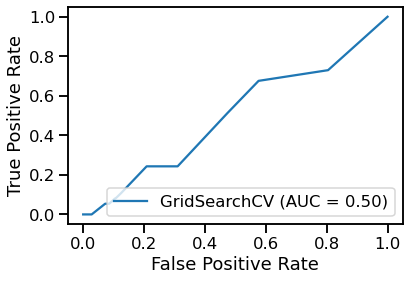

In [78]:
plot_roc_curve(gsCV_log_reg, X_test, y_test)

In [79]:
con_ma = confusion_matrix(y_test, y_preds)

Text(-1.5, 0.5, 'Predicted values')

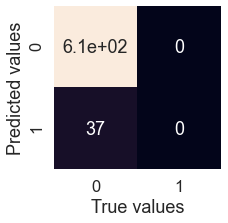

In [80]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(3,3))
ax = sns.heatmap(con_ma, annot=True, cbar=False)
plt.xlabel('True values')
plt.ylabel('Predicted values')

In [81]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       609
           1       0.00      0.00      0.00        37

    accuracy                           0.94       646
   macro avg       0.47      0.50      0.49       646
weighted avg       0.89      0.94      0.91       646



F:\ML_course\bismillah\env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Classification Evaluation Metrics using CV

In [82]:
gsCV_log_reg.best_params_

{'ml_model__C': 0.0001, 'ml_model__solver': 'liblinear'}

In [83]:
estm = Pipeline(steps=[('preprocess', preprocessor),
                      ('Ml_model', LogisticRegression())])

gsCV_grid = {"Ml_model__C": [0.0001],
             "Ml_model__solver": ["liblinear"]}

model = GridSearchCV(estm,
                            gsCV_grid,
                            cv=5,
                            verbose=True)


In [84]:
gsCV_Lsvc.best_params_

{'ml_model__C': 1, 'ml_model__max_iter': 1, 'ml_model__verbose': 4}

In [85]:
es = Pipeline(steps=[('preprocess', preprocessor),
                      ('ml_model', LinearSVC())])

gsCV_gr = {'ml_model__C': [1], 'ml_model__max_iter': [1], 'ml_model__verbose': [4]}

mod = GridSearchCV(es,
                            gsCV_gr,
                            cv=5,
                            verbose=True)


In [90]:
# Cross-validated accuracy
cv_Acc = np.mean(cross_val_score(mod, X, y, cv=5, scoring='accuracy'))
cv_Acc

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.

[LibLinear][LibLinear][LibLinear][LibLinear]Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.8641911444979232

In [86]:
# Cross-validated precision
cv_Prec = np.mean(cross_val_score(mod,
                         X,
                         y,
                         cv=5,
                         scoring="precision"))
cv_Prec

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.

[LibLinear][LibLinear][LibLinear][LibLinear]Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.023157894736842106

In [87]:
# Cross-validated recall
cv_rec = np.mean(cross_val_score(mod,
                         X,
                         y,
                         cv=5,
                         scoring="recall"))
cv_rec

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: Con

0.13529411764705884

In [88]:
# Cross-validated f1
cv_f1 = np.mean(cross_val_score(mod, X, y, cv=5, scoring='f1'))
cv_f1

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibLinear]

F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of 

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
F:\ML_course\bismillah\env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.022775800711743767

<AxesSubplot:title={'center':'Cross-Validated metrics for Linear SVC'}>

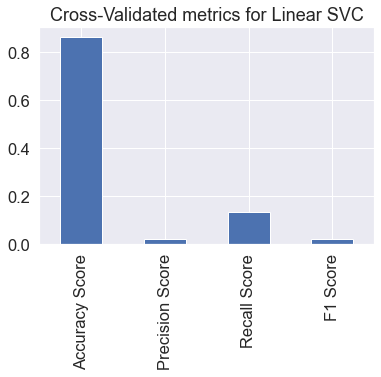

In [91]:
cv_metrics = pd.DataFrame({'Accuracy Score' : cv_Acc,
                           'Precision Score' : cv_Prec,
                           'Recall Score' : cv_rec,            
                           'F1 Score' : cv_f1}, index=[0])
cv_metrics.T.plot(title='Cross-Validated metrics for Linear SVC', legend=False, kind='bar')

### *Feature importance*
which features contributed most to the outcomes of the model and how did they contribute?

In [92]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('category',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['seismic',
                                                                          'seismoacoustic',
                                                                          'shift',
                                                                          'hazard'])])),
                                       ('Ml_model', LogisticRegression())]),
             param_grid={'Ml_model__C': [0.0001],
                         'Ml_model__solver': ['liblinear']},
             verbose=True)

In [93]:
model.best_estimator_.named_steps['Ml_model'].coef_

array([[-0.04908484, -0.02267184, -0.04370646, -0.02665778, -0.00139244,
        -0.02897052, -0.04278616, -0.06486963, -0.00601474, -0.00087232]])

In [94]:
coeff = model.best_estimator_.steps[1][1].coef_

In [95]:
data.dtypes

seismic           object
seismoacoustic    object
shift             object
genergy            int64
gpuls              int64
gdenergy           int64
gdpuls             int64
hazard            object
nbumps             int64
nbumps2            int64
nbumps3            int64
nbumps4            int64
nbumps5            int64
energy             int64
maxenergy          int64
class              int64
dtype: object

In [96]:
feats_dick = dict(zip(data.columns, list(coeff[0])))
feats_dick

{'seismic': -0.04908483892078417,
 'seismoacoustic': -0.02267184464978948,
 'shift': -0.043706462074488805,
 'genergy': -0.02665777796488657,
 'gpuls': -0.0013924435311976691,
 'gdenergy': -0.028970523105888477,
 'gdpuls': -0.042786160464684767,
 'hazard': -0.0648696277142122,
 'nbumps': -0.006014740004095781,
 'nbumps2': -0.0008723158522647358}

<AxesSubplot:title={'center':'Feature Importance'}>

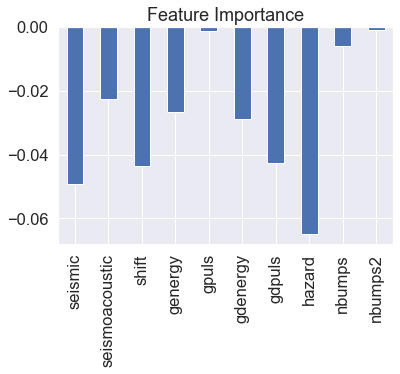

In [98]:
pd.DataFrame(feats_dick, index=[0]).T.plot.bar(title='Feature Importance', legend=False)

In [100]:
pd.crosstab(data.hazard, data['class'])

class,0,1
hazard,,
a,2186,156
b,198,14
c,30,0


**Most of the attributes contribute very less to target variables. As a result the different models performed same. We can confer, the dataset was not useful enough to predict targets.**

## 6. Experimentation
* Could more data be collected?
* Could a better model be tried? Like CatBoost or XGBoost?
* Could the current models be improved? (beyond what we've done so far)

**Export & Share**
